 # Proyecto Volcano
 
 Datos obtenidos del grupo @Natura??

## Análisis exploratorio de los datos

En este cuaderno vamos a abrir y explorar en que consiste la base de datos.

Para ello, comenzamos importamos las bibliotecas que necesitaremos más adelante: pandas, numpy, pyploy (en matplotlib) y signal (en scipy).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

La base de datos, que se encuentra en el archivo "MicSigV1_v1_1.json", que utilizamos a continuación, fue conformada por el Instituto Geofísico de la Escuela Politécnica Nacional de Ecuador. Estos datos corresponden a un catálogo de diferentes eventos sísmicos registrados en el volcán Cotopaxi.

Como solo contamos con permiso para uso académico, no podemos compartir el archivo con terceros.

Entonces, leemos el archivo y hacemos una primera inspección de la serie de datos.

In [2]:
json_file = './dataset/MicSigV1_v1_1.json'
sism_events = pd.read_json(json_file)
# Mostramos el DataFrame con las primeros 5 filas, para tener una primera idea
sism_events.head(5)

,Network,Station,SampleRate,Component,Year,Month,Type,Duration,StartPoint,EndPoint,Data
0,EC,VC1,100,SHZ,2012,1,VT,23,1001,3301,"[23.355529956093186, -26.21249638722304, 7.478..."
1,EC,VC1,100,SHZ,2012,1,LP,47,1001,5701,"[-9.39456702711197, 5.797439374378022, -23.901..."
2,EC,VC1,100,SHZ,2012,1,LP,56,1001,6601,"[-3.915706523024276, 0.420532668769778, -21.37..."
3,EC,VC1,100,SHZ,2012,1,VT,49,1001,5901,"[-2.5686254658527723, 23.91770870655175, -10.7..."
4,EC,VC1,100,SHZ,2012,1,VT,31,1001,4101,"[55.05791051352128, 41.33929940327658, -19.424..."


Una breve descripción de las columnas que componen el DataFrame.

* **Network:** red sísmica;
* **Station:** nombre de la estación sísmica,
* **SampleRate:** cantidad de datos del digitalizador por unidad de tiempo (segundos);
* **Component:** conjunto de tres letras cuya última establece la dirección de medición. En este caso, Z indica la dirección vertical del movimiento.
* **Type:** tipo de evento sísmico;
* **Duration:** duración del evento, desde StartPoint hasta EndPoint, en segundos;
* **StartPoint:** inicio del evento en de la serie temporal del conjunto de datos (Data); > ¿por defecto siempre descarta los primeros 1000 puntos?
* **EndPoint:** fin del evento en de la serie temporal del conjunto de datos (Data);
* **Data:** conjunto de datos.

Los datos de mayor interés, son los grupos de datos que se encuentran en **Data**.
Todas nuestras columnas, o variables, parecen ser categóricas, salvo por Data.
Intentamos sacar información adicional, del resto de las columnas. Por ejemplo, cuantas redes y estaciones sísmicas hay.

In [3]:
sism_events.Network.value_counts()

EC    1187
Name: Network, dtype: int64

In [4]:
sism_events.Station.value_counts()

BREF    706
VC1     481
Name: Station, dtype: int64

Bien, contamos con un tipo de red sísmica (lo cual nos dice nada, se podría descartar) y dos estaciones sísmicas.
Ahora, veamos los tipos de componentes.

In [5]:
sism_events.Component.value_counts()

BHZ    706
SHZ    481
Name: Component, dtype: int64

Por último, tenemos los eventos sísmicos.

In [6]:
print('Nro. de eventos totales: ', len(sism_events.Type))
sism_events.Type.value_counts()

Nro. de eventos totales:  1187


LP          1044
VT           101
REGIONAL      27
HB             8
ICEQUAKE       7
Name: Type, dtype: int64

Cada evento sísmico refleja un proceso con origen en distintos tipos de fuente. Los sismos más destacados, en actividad volcánica, son:

**VT (volcano-tectonic):** son consecuencia de la ruptura frágil de la corteza;
**LP (long period):** se deben a la agitación de un sistema que involucra un fluido.

Quedemonos con los sismos tipos LP, que son los mayoritarios, y grafiquemos un conjunto de datos.

In [7]:
# Nuestro nuevo DataFrame, con solo eventos tipo LP
LP_events = sism_events[sism_events.Type == 'LP']

# N° de filas de LP_events
n_LP = len(LP_events)

# Otra forma, dimension
#dim_LP = LP_events.shape

# Nos quedamos con el primer evento
LP1 = LP_events.iloc[0]

(0.0, 10.0)

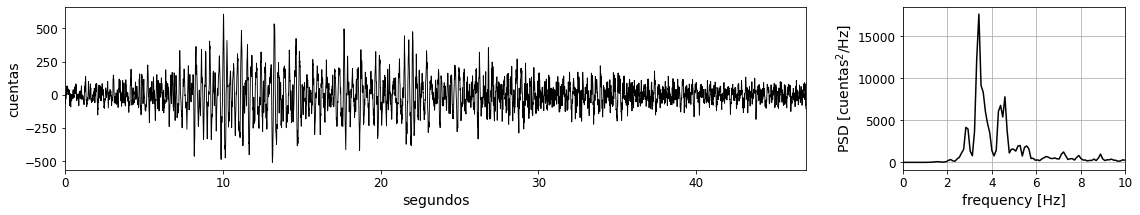

In [8]:
# forma de onda
LP_waveform = LP1.Data[LP1.StartPoint:LP1.EndPoint]

N_points = len(LP_waveform)


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

time = np.linspace(0, LP1.Duration, N_points)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 3), gridspec_kw=dict(width_ratios=[10,3]))

ax1.plot(time, LP_waveform, 'k', lw=0.9)
ax1.set_ylabel('cuentas')
ax1.set_xlabel('segundos')
ax1.set_xlim(0, LP1.Duration)

# PSD
f, PSD = signal.welch(LP_waveform, LP1.SampleRate, nperseg=1024, scaling='density')
ax2.plot(f, PSD, color='k')
ax2.set_xlabel('frequency [Hz]')
ax2.set_ylabel(r'PSD [cuentas$^2$/Hz]')
ax2.grid()
ax2.set_xlim(0, 10)

## Planteando el problema

No todas las señales LP son iguales

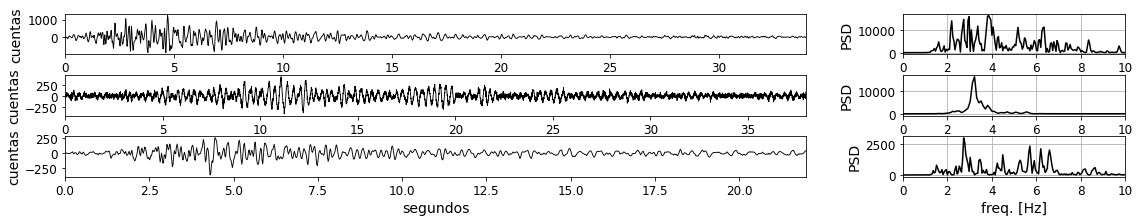

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(19, 3), gridspec_kw=dict(width_ratios=[10,3], hspace=0.5))
for k in range(3):
    LP_k = LP_events.iloc[np.random.randint(0, 1044)]
    LP_waveform = LP_k.Data[LP_k.StartPoint:LP_k.EndPoint]
    N_points = len(LP_waveform)
    time = np.linspace(0, LP_k.Duration, N_points)
    axes[k][0].plot(time, LP_waveform, 'k', lw=0.9)
    axes[k][0].set_ylabel('cuentas')
    axes[k][0].set_xlabel('segundos')
    axes[k][0].set_xlim(0, LP_k.Duration)

    nps = 1024
    if N_points < nps:
        nps = 512

    f, PSD = signal.welch(LP_waveform, LP_k.SampleRate, nperseg=nps, scaling='density')
    axes[k][1].plot(f, PSD, color='k')
    axes[k][1].set_xlabel('freq. [Hz]')
    axes[k][1].set_ylabel(r'PSD')
    axes[k][1].grid()
    axes[k][1].set_xlim(0, 10)

Clasificando manualmente, en subgrupos a partir de un análisis visual.

## El objetivo del proyecto es: 

Diseñar un algortimo no-supervisado o semisupervisado a partir de features extraidos de las señales capaz de clasificar estos LP en subcategorias o subtipos

## Principal Component Analysis

In [10]:
# Leemos el archivo JSON generado 
parameters_file = './codigos/LP_parametros_1.json'
parameters = pd.read_json(parameters_file)
# Mostramos el DataFrame con las primeros 5 filas, para tener una primera idea
parameters.head(5)

,Duration,NroPeaks_th_50,NroPeaks_th_75,NroPeaks_th_90,MaxPeakFreq,MaxPeakWidth,MaxPeakEnergy,CentroidPSD,CentroidPSD_1-10,DetrendedFluctuation,...,SVDEntropy_d7_t3,NroZerocross_d7_t3,HjorthComplex_d7_t3,HjorthMobil_d7_t3,AppEntropy_d7_t5,PermEntropy_d7_t5,SVDEntropy_d7_t5,NroZerocross_d7_t5,HjorthComplex_d7_t5,HjorthMobil_d7_t5
LP_0,47.0,5,1,1,3.613281,9482.071622,1.662655,6.611592,4.401532,0.596956,...,0.816377,0.098298,0.287167,1.293452,0.379196,0.873853,0.916746,0.098298,0.287167,1.293452
LP_1,56.0,1,1,1,3.613281,57272.156772,2.638270,4.348629,3.888320,0.612458,...,0.755527,0.080000,0.248392,1.248269,0.258719,0.800181,0.877224,0.080000,0.248392,1.248269
LP_2,29.0,2,2,2,2.929688,7192.385936,1.581080,5.772776,3.736426,0.796333,...,0.788069,0.084828,0.250977,1.331926,0.361207,0.801916,0.893987,0.084828,0.250977,1.331926
LP_3,33.0,1,1,1,3.125000,13302.140632,2.249850,5.180334,3.730017,0.796204,...,0.762959,0.079697,0.230923,1.343898,0.309659,0.780613,0.882441,0.079697,0.230923,1.343898
LP_4,42.0,1,1,1,3.613281,4217.605887,1.820869,8.289298,4.065018,0.666097,...,0.826119,0.092143,0.275384,1.363867,0.391407,0.855314,0.924141,0.092143,0.275384,1.363867


In [11]:
# ValueError: could not convert string to float: 'db38'
#pca = PCA(n_components=5)
#pca.fit(parameters)

In [12]:
#parameters.value_counts()

In [13]:
#copia = sism_events.drop(['Data'], axis=1)

In [14]:
#pca = PCA(n_components=5)
#pca.fit(copia)

In [29]:
# Listo el nombre de las columnas
columns_names = parameters.columns.values
# Convierto el NumPy array a lista
#columns_names_list = list(columns_names)
list(columns_names)

['Duration',
 'NroPeaks_th_50',
 'NroPeaks_th_75',
 'NroPeaks_th_90',
 'MaxPeakFreq',
 'MaxPeakWidth',
 'MaxPeakEnergy',
 'CentroidPSD',
 'CentroidPSD_1-10',
 'DetrendedFluctuation',
 'HiguchiFd',
 'KatzFd',
 'PetrosianFd',
 'BestWavelet',
 'BestWaveletFq',
 'AppEntropy_d3_t1',
 'PermEntropy_d3_t1',
 'SVDEntropy_d3_t1',
 'NroZerocross_d3_t1',
 'HjorthComplex_d3_t1',
 'HjorthMobil_d3_t1',
 'AppEntropy_d3_t3',
 'PermEntropy_d3_t3',
 'SVDEntropy_d3_t3',
 'NroZerocross_d3_t3',
 'HjorthComplex_d3_t3',
 'HjorthMobil_d3_t3',
 'AppEntropy_d3_t5',
 'PermEntropy_d3_t5',
 'SVDEntropy_d3_t5',
 'NroZerocross_d3_t5',
 'HjorthComplex_d3_t5',
 'HjorthMobil_d3_t5',
 'AppEntropy_d5_t1',
 'PermEntropy_d5_t1',
 'SVDEntropy_d5_t1',
 'NroZerocross_d5_t1',
 'HjorthComplex_d5_t1',
 'HjorthMobil_d5_t1',
 'AppEntropy_d5_t3',
 'PermEntropy_d5_t3',
 'SVDEntropy_d5_t3',
 'NroZerocross_d5_t3',
 'HjorthComplex_d5_t3',
 'HjorthMobil_d5_t3',
 'AppEntropy_d5_t5',
 'PermEntropy_d5_t5',
 'SVDEntropy_d5_t5',
 'NroZerocros

In [59]:
parameters.BestWavelet.dtype

dtype('O')

In [60]:
parameters.HjorthMobil_d7_t5.dtype

dtype('float64')

In [61]:
parameters.BestWaveletFq[0]

'db27'

In [62]:
str(parameters.BestWavelet)

'LP_0       db38\nLP_1       db15\nLP_2       db26\nLP_3       db34\nLP_4       db38\n           ... \nLP_1039    db26\nLP_1040    db38\nLP_1041    db27\nLP_1042    db23\nLP_1043    db36\nName: BestWavelet, Length: 1044, dtype: object'

In [63]:
type(parameters.BestWavelet[0])

str

In [64]:
# Me fijo los tipos de datos
parameters.dtypes

Duration               float64
NroPeaks_th_50           int64
NroPeaks_th_75           int64
NroPeaks_th_90           int64
MaxPeakFreq            float64
                        ...   
PermEntropy_d7_t5      float64
SVDEntropy_d7_t5       float64
NroZerocross_d7_t5     float64
HjorthComplex_d7_t5    float64
HjorthMobil_d7_t5      float64
Length: 69, dtype: object

In [71]:
# Como no encuentro por columnas, reviso por filas
#parameters.applymap(np.isreal)
# Como es muy largo de chequear, me fijo si hay alguna particularmente
#parameters.applymap(np.isreal).all(1)
# Alguna fila con algun dato no numerico? (no estaría funcionando, muestra todos)
#parameters[~parameters.applymap(np.isreal).all(1)]
# El primer dato no numerico que encuentra (no funciona tampoco, muestra un ¿cero?)
#np.argmin(parameters.applymap(np.isreal).all(1))

In [72]:
# Otra opcion
#num_df = (parameters.drop(columns_names, axis=1)
#         .join(parameters[columns_names].apply(pd.to_numeric, errors='coerce')))
#num_df = num_df[num_df[columns_names].notnull().all(axis=1)]

In [73]:
num_df

,Duration,NroPeaks_th_50,NroPeaks_th_75,NroPeaks_th_90,MaxPeakFreq,MaxPeakWidth,MaxPeakEnergy,CentroidPSD,CentroidPSD_1-10,DetrendedFluctuation,...,SVDEntropy_d7_t3,NroZerocross_d7_t3,HjorthComplex_d7_t3,HjorthMobil_d7_t3,AppEntropy_d7_t5,PermEntropy_d7_t5,SVDEntropy_d7_t5,NroZerocross_d7_t5,HjorthComplex_d7_t5,HjorthMobil_d7_t5
LP_0,47.0,5,1,1,3.613281,9.482072e+03,1.662655,6.611592,4.401532,0.596956,...,0.816377,0.098298,0.287167,1.293452,0.379196,0.873853,0.916746,0.098298,0.287167,1.293452
LP_1,56.0,1,1,1,3.613281,5.727216e+04,2.638270,4.348629,3.888320,0.612458,...,0.755527,0.080000,0.248392,1.248269,0.258719,0.800181,0.877224,0.080000,0.248392,1.248269
LP_2,29.0,2,2,2,2.929688,7.192386e+03,1.581080,5.772776,3.736426,0.796333,...,0.788069,0.084828,0.250977,1.331926,0.361207,0.801916,0.893987,0.084828,0.250977,1.331926
LP_3,33.0,1,1,1,3.125000,1.330214e+04,2.249850,5.180334,3.730017,0.796204,...,0.762959,0.079697,0.230923,1.343898,0.309659,0.780613,0.882441,0.079697,0.230923,1.343898
LP_4,42.0,1,1,1,3.613281,4.217606e+03,1.820869,8.289298,4.065018,0.666097,...,0.826119,0.092143,0.275384,1.363867,0.391407,0.855314,0.924141,0.092143,0.275384,1.363867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP_1039,23.0,6,2,2,6.005859,3.784653e+04,5.430795,5.829834,5.236132,0.438953,...,0.957658,0.221739,0.734430,1.212808,0.186747,0.798068,0.982594,0.221739,0.734430,1.212808
LP_1040,28.0,1,1,1,7.177734,2.105498e+06,4.041362,7.276029,6.766081,0.238125,...,0.865390,0.260714,0.844627,1.076189,0.165351,0.818749,0.978382,0.260714,0.844627,1.076189
LP_1041,46.0,1,1,1,3.125000,9.168787e+05,1.990727,3.891596,3.845711,0.491553,...,0.964726,0.156522,0.514920,1.253431,0.223636,0.854618,0.950793,0.156522,0.514920,1.253431
LP_1042,32.0,11,4,1,3.076172,3.074233e+03,1.837172,5.671285,5.356743,0.415637,...,0.967816,0.182500,0.711681,1.207563,0.271903,0.822304,0.976249,0.182500,0.711681,1.207563


In [70]:
# Prueba
#pca = PCA(n_components=5)
#num_df_5D = pca.fit_transform(num_df)

In [74]:
# ¿Cuantos son NaN?
dim = num_df.shape
acum = 0
for i in range(dim[1]):
    #acum += 
    False
#num_df.isnull(num_df[columns_names_list[i]])
for j in range(dim[1]):
    for i in range(dim[0]):
        if num_df[columns_names[j]].isnull()[i] == True:
            acum += 1
acum

2088

In [83]:
#  Ahora convierto los NaN a 0
copia = num_df.copy()
dim = copia.shape

for i in range(dim[1]):
    # Completar todos los valores NaN con ceros
    copia[columns_names[i]] = copia[columns_names[i]].fillna(0)

In [84]:
corr_matrix = copia.corr()
corr_matrix["Duration"].sort_values(ascending=False)

Duration              1.000000
PermEntropy_d7_t5     0.459924
AppEntropy_d7_t5      0.425992
AppEntropy_d7_t3      0.425992
AppEntropy_d7_t1      0.425992
                        ...   
NroZerocross_d3_t1   -0.667858
NroZerocross_d5_t3   -0.667858
PetrosianFd          -0.699512
BestWavelet                NaN
BestWaveletFq              NaN
Name: Duration, Length: 69, dtype: float64

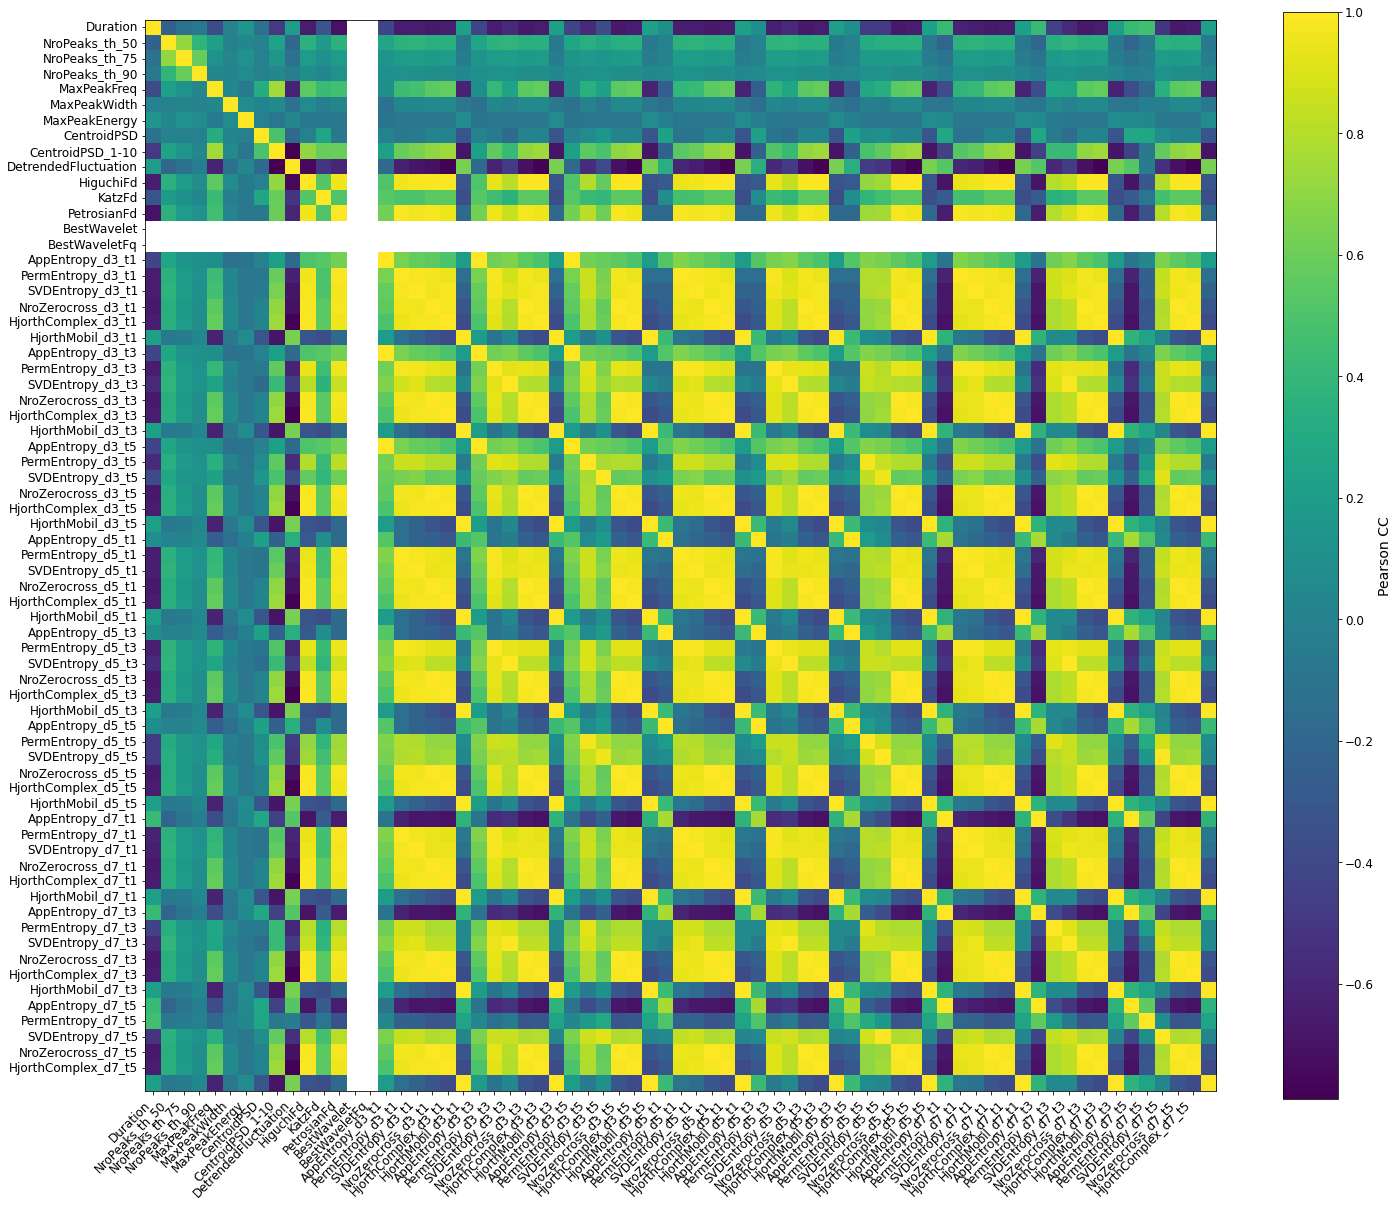

In [85]:
fig = plt.figure(figsize=(24, 20))
ax = fig.add_subplot()

plt.imshow(corr_matrix)

# Set ticks
xt = plt.xticks(np.arange(dim[1]-1), copia.columns[:-1], rotation=45, ha='right', va='top')
yt = plt.yticks(np.arange(dim[1]-1), copia.columns[:-1], rotation=0, ha='right', va='center')

# Set colorbar
plt.colorbar(label='Pearson CC')

In [93]:
# Prueba
pca1 = PCA(n_components=5)
copia_5D = pca1.fit_transform(copia)

In [94]:
copia_5D.shape

(1044, 5)

In [95]:
copia_de_copia = copia.copy()
dim = copia_de_copia.shape

# Pruebo a ver si convirtio los string a NaN
pca2 = PCA(n_components=5)
copia_de_copia_5D = pca2.fit_transform(copia_de_copia)

In [100]:
copia_de_copia_5D.shape

(1044, 5)

In [91]:
#pca.components_

In [96]:
pca2.explained_variance_ratio_

array([1.00000000e+00, 4.41300903e-13, 1.28397476e-14, 5.34888535e-15,
       2.64934197e-15])

In [101]:
pca2.explained_variance_ratio_.cumsum()

array([1., 1., 1., 1., 1.])

In [102]:
print(np.cov(copia_de_copia_5D.T))

[[ 5.19516348e+14  9.39180330e-09 -5.78951366e-10  2.12070097e-10
  -2.86406247e-10]
 [ 9.39180330e-09  2.29263034e+02 -6.70945136e-15  1.06615473e-15
  -2.77608979e-15]
 [-5.78951366e-10 -6.70945136e-15  6.67045877e+00 -5.26903545e-17
   4.08882473e-16]
 [ 2.12070097e-10  1.06615473e-15 -5.26903545e-17  2.77883338e+00
   1.13342807e-15]
 [-2.86406247e-10 -2.77608979e-15  4.08882473e-16  1.13342807e-15
   1.37637647e+00]]


In [103]:
m = np.cov(copia_de_copia.T)[0]
m[::-1].sort()

In [105]:
m.shape

(69,)

In [106]:
m

array([ 2.37856091e+06,  2.28093236e+02,  2.25322502e+00,  4.08532579e-01,
        4.08532579e-01,  4.08532579e-01,  4.05440277e-01,  3.59767105e-01,
        3.59767105e-01,  3.59767105e-01,  3.59767105e-01,  3.59767105e-01,
        3.59767105e-01,  3.59767105e-01,  3.59767105e-01,  3.59767105e-01,
        2.48219550e-01,  9.41406172e-02,  9.41406172e-02,  9.41406172e-02,
        0.00000000e+00,  0.00000000e+00, -4.44887677e-02, -1.82421435e-01,
       -2.11187677e-01, -2.87039118e-01, -3.28417372e-01, -3.43079736e-01,
       -4.52158834e-01, -5.20089100e-01, -5.83743805e-01, -5.83743805e-01,
       -5.83743805e-01, -6.07601409e-01, -6.07601409e-01, -6.07601409e-01,
       -6.07601409e-01, -6.07601409e-01, -6.07601409e-01, -6.07601409e-01,
       -6.07601409e-01, -6.07601409e-01, -6.56613278e-01, -7.50019058e-01,
       -8.02650967e-01, -8.04881023e-01, -8.40594390e-01, -9.49426492e-01,
       -9.78944768e-01, -1.06824132e+00, -1.10840503e+00, -1.20508298e+00,
       -1.26043092e+00, -

In [107]:
copia_de_copia.var(axis=0)

Duration               228.093236
NroPeaks_th_50           6.281479
NroPeaks_th_75           1.085958
NroPeaks_th_90           0.263125
MaxPeakFreq              2.049393
                          ...    
PermEntropy_d7_t5        0.001277
SVDEntropy_d7_t5         0.001775
NroZerocross_d7_t5       0.003629
HjorthComplex_d7_t5      0.040750
HjorthMobil_d7_t5        0.011695
Length: 69, dtype: float64

In [108]:
# Va a dominar Duration, entonces hay que escalar

# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(copia_de_copia)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [109]:
#display scree plot of pca

In [112]:
modelo_copia_5D = modelo_pca.components_

In [114]:
modelo_copia_5D.shape

(69, 69)

In [131]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_copia_5D, #data = modelo_pca.components_
    columns = copia.columns,
    index   = list(range(modelo_copia_5D.shape[0]))
)

,Duration,NroPeaks_th_50,NroPeaks_th_75,NroPeaks_th_90,MaxPeakFreq,MaxPeakWidth,MaxPeakEnergy,CentroidPSD,CentroidPSD_1-10,DetrendedFluctuation,...,SVDEntropy_d7_t3,NroZerocross_d7_t3,HjorthComplex_d7_t3,HjorthMobil_d7_t3,AppEntropy_d7_t5,PermEntropy_d7_t5,SVDEntropy_d7_t5,NroZerocross_d7_t5,HjorthComplex_d7_t5,HjorthMobil_d7_t5
0,0.106973,-6.035691e-02,-3.369865e-02,-1.745871e-02,-8.883895e-02,-7.833387e-03,1.415157e-02,-2.321785e-03,-1.160447e-01,1.187387e-01,...,-1.406064e-01,-0.158163,-0.159005,0.052067,0.110893,4.094667e-02,-1.343653e-01,-1.581626e-01,-1.590051e-01,5.206739e-02
1,-0.001448,2.730559e-02,1.805509e-02,3.198163e-02,-1.304971e-01,-3.338566e-02,5.819015e-03,-5.722452e-02,-1.214323e-01,1.129088e-01,...,1.115374e-01,-0.002021,-0.021843,0.255016,0.096534,1.020542e-01,1.037252e-01,-2.020972e-03,-2.184334e-02,2.550164e-01
2,0.006718,-2.689995e-02,-2.233994e-02,-1.698580e-02,-1.217694e-01,4.446074e-02,3.115876e-02,-2.939256e-01,-1.696577e-01,8.425906e-02,...,3.509146e-02,0.008031,0.012295,0.133070,-0.248975,-2.258572e-01,-5.313389e-02,8.031476e-03,1.229496e-02,1.330700e-01
3,0.117378,4.522925e-01,5.533471e-01,4.666650e-01,4.739649e-02,8.167509e-02,1.916140e-01,5.028565e-02,5.187635e-02,-8.114860e-02,...,3.773332e-02,-0.041229,-0.002400,0.001811,0.022249,1.967881e-01,7.852726e-02,-4.122913e-02,-2.400167e-03,1.811470e-03
4,-0.183301,2.619467e-01,3.039157e-01,2.646576e-01,-2.033983e-02,-1.011338e-01,-9.182740e-03,-1.365471e-01,-1.115402e-01,2.122801e-01,...,-4.620063e-02,0.041737,-0.010401,-0.019575,-0.036421,-4.336450e-01,-1.566304e-01,4.173710e-02,-1.040090e-02,-1.957486e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,-0.000000,3.964850e-18,1.588808e-17,-2.509159e-17,3.700124e-18,-5.554175e-18,7.928825e-18,-1.884966e-17,-1.318815e-17,-5.373847e-18,...,-8.012954e-18,0.489953,-0.287690,0.468050,-0.018178,-1.313421e-17,8.528382e-18,-1.450382e-16,-2.577974e-16,3.350663e-17
65,0.000000,-1.316584e-17,-5.845674e-18,8.025771e-18,-2.151717e-17,-7.606782e-18,2.219696e-18,1.102106e-18,-7.235065e-18,-1.324273e-17,...,2.035044e-18,0.355388,0.448770,-0.281610,0.285236,-6.070891e-18,-2.826423e-18,9.427122e-17,7.089840e-17,-2.014538e-17
66,0.000000,-1.222466e-17,1.069853e-17,1.466831e-17,-2.716489e-19,5.667559e-18,-3.496655e-17,4.153272e-18,4.753225e-18,-2.981693e-18,...,-9.250974e-18,0.011843,-0.485659,-0.391901,0.358008,1.512228e-17,5.758786e-18,1.671979e-17,5.787761e-17,-2.649256e-17
67,-0.000000,3.612376e-17,-1.563844e-17,1.139662e-17,-4.470195e-17,1.840723e-17,-9.727567e-18,4.047077e-18,-1.257567e-17,2.671067e-18,...,2.159988e-17,-0.143616,0.067074,0.403918,0.535289,6.243053e-18,9.561586e-18,1.050850e-16,1.196454e-16,-3.652733e-17


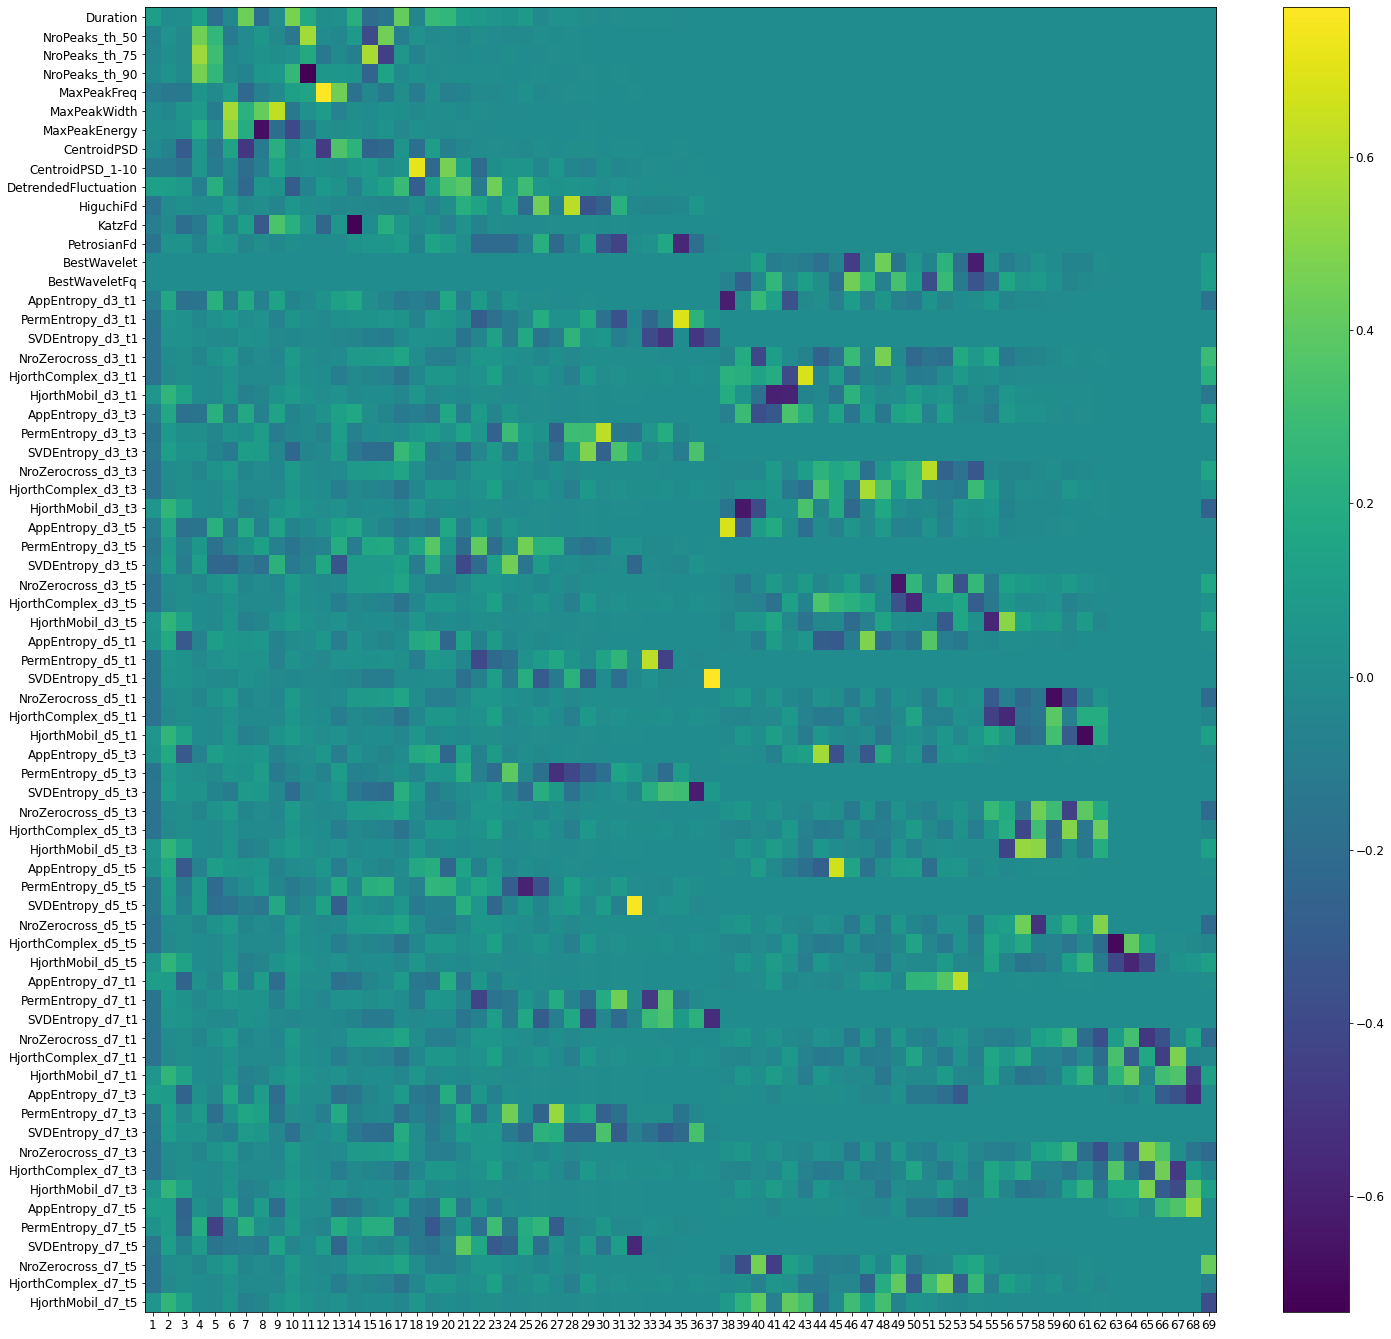

In [133]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(copia.columns)), copia.columns)
plt.xticks(range(len(copia.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[5.78278590e-01 1.81522903e-01 7.22332146e-02 2.99044807e-02
 2.90752272e-02 1.71217615e-02 1.52728439e-02 1.40062847e-02
 1.26317644e-02 1.06086120e-02 8.83427847e-03 5.99435681e-03
 5.37344473e-03 4.96856804e-03 3.60574617e-03 3.24205083e-03
 1.92158799e-03 1.36358706e-03 9.65916302e-04 8.40402348e-04
 6.43290924e-04 4.98212928e-04 3.75334728e-04 2.61845591e-04
 1.70378399e-04 1.01980135e-04 5.65167630e-05 4.76026226e-05
 2.36017081e-05 1.85278078e-05 1.60762007e-05 1.04487311e-05
 4.25351781e-06 3.28561202e-06 1.66596494e-06 1.21435611e-06
 1.43539914e-07 9.26392776e-33 3.13688628e-33 3.13688628e-33
 3.13688628e-33 3.13688628e-33 3.13688628e-33 3.13688628e-33
 3.13688628e-33 3.13688628e-33 3.13688628e-33 3.13688628e-33
 3.13688628e-33 3.13688628e-33 3.13688628e-33 3.13688628e-33
 3.13688628e-33 3.13688628e-33 3.13688628e-33 3.

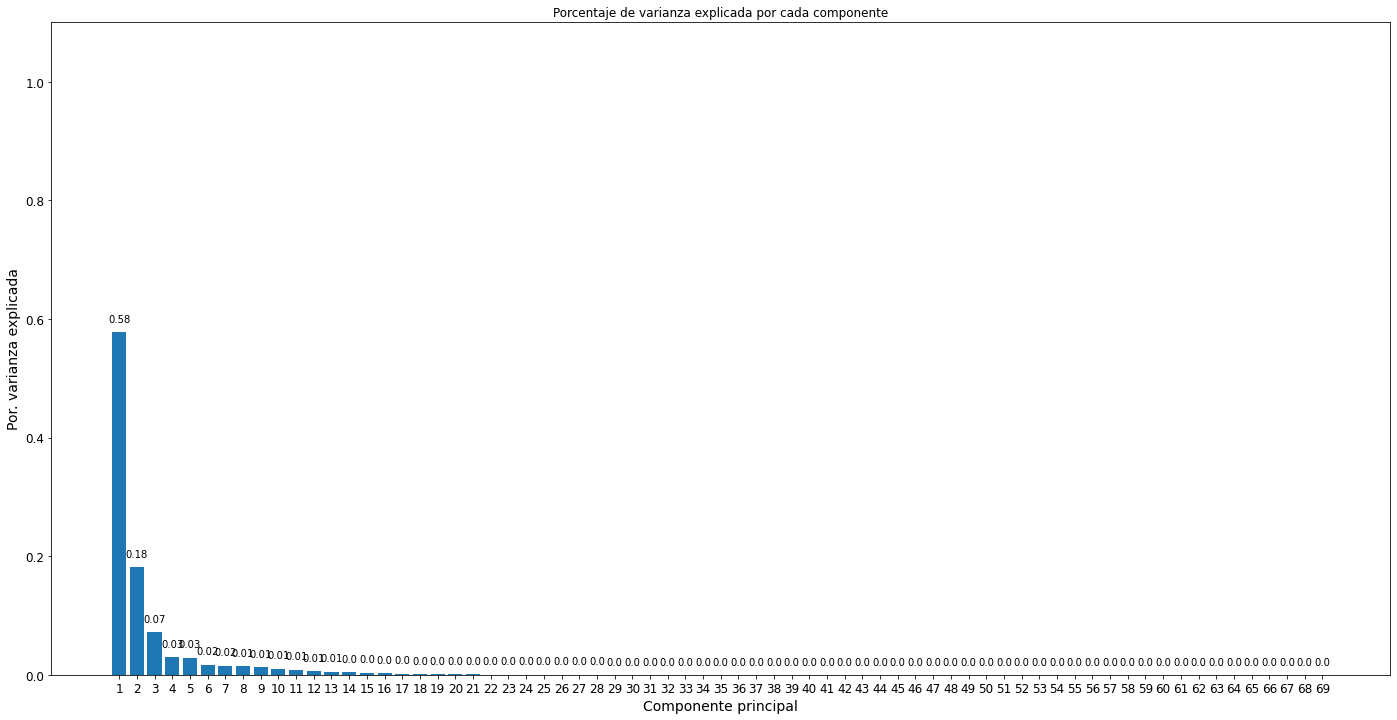

In [146]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(copia.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.57827859 0.75980149 0.83203471 0.86193919 0.89101442 0.90813618
 0.92340902 0.93741531 0.95004707 0.96065568 0.96948996 0.97548432
 0.98085776 0.98582633 0.98943208 0.99267413 0.99459571 0.9959593
 0.99692522 0.99776562 0.99840891 0.99890712 0.99928246 0.9995443
 0.99971468 0.99981666 0.99987318 0.99992078 0.99994438 0.99996291
 0.99997899 0.99998944 0.99999369 0.99999698 0.99999864 0.99999986
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


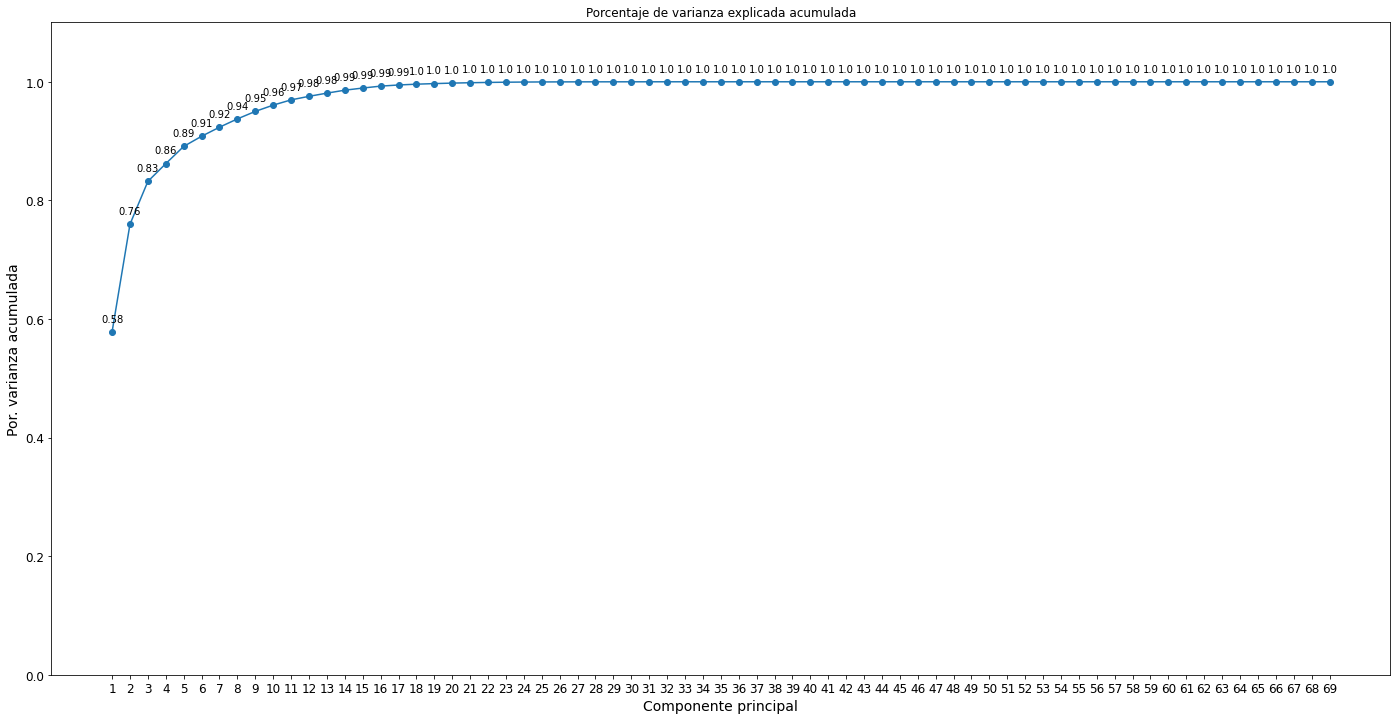

In [137]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
ax.plot(
    np.arange(len(copia.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(copia.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X = copia)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = list(range(modelo_copia_5D.shape[0])),
    index   = copia.index
)
proyecciones.head()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
LP_0,6.012502,2.128754,-3.962518,0.015104,-0.892637,-0.166961,-0.143554,1.018505,-0.284414,0.326114,...,-5.356127e-17,1.240327e-16,-1.257675e-16,-1.031569e-16,-1.180905e-16,-2.322705e-16,4.520652e-17,2.725051e-16,2.181365e-16,-1.332268e-15
LP_1,7.993602,-2.393978,1.127534,-0.802577,0.175944,-0.257742,0.695665,-0.303577,0.113737,0.450167,...,-2.369334e-16,1.584290e-16,-2.265169e-16,-8.975388e-17,1.208377e-16,-2.185742e-16,1.236731e-16,-5.143693e-18,-1.903193e-16,9.089951e-16
LP_2,7.901697,1.980549,-1.704205,-0.129089,1.985353,0.247626,-1.252698,1.158624,0.160150,0.566526,...,-8.920282e-17,5.941428e-17,-1.487525e-16,-3.583612e-16,3.659818e-18,-3.696147e-16,1.798405e-17,3.264066e-16,-3.016655e-16,-5.551115e-16
LP_3,9.008848,0.568735,0.684177,-1.553968,1.299272,0.345346,-1.248228,0.015196,0.467927,0.107876,...,-2.202811e-16,-2.831936e-16,-3.981190e-16,-9.532186e-17,2.325992e-16,-3.605912e-16,2.271136e-16,8.365208e-17,-1.108582e-16,2.220446e-15
LP_4,6.745507,3.751071,-3.729282,-0.991856,-0.805838,0.525117,-1.313469,0.324653,0.438759,0.670335,...,-1.373038e-16,6.071532e-17,1.808449e-16,-1.645307e-16,-1.177546e-16,-3.942915e-16,2.096069e-17,3.543424e-16,-4.699377e-17,-3.330669e-15


In [145]:
# De forma manual
proyecciones = np.dot(modelo_pca.components_, scale(copia).T)
proyecciones = pd.DataFrame(proyecciones, index = list(range(modelo_copia_5D.shape[0])))
proyecciones = proyecciones.transpose().set_index(copia.index)
proyecciones.head()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
LP_0,6.012502,2.128754,-3.962518,0.015104,-0.892637,-0.166961,-0.143554,1.018505,-0.284414,0.326114,...,-9.349931e-17,7.407799e-17,-1.583046e-16,-1.018742e-17,-2.228767e-17,-2.738781e-16,6.124565e-17,1.289322e-16,-3.773468e-16,-9.436896e-16
LP_1,7.993602,-2.393978,1.127534,-0.802577,0.175944,-0.257742,0.695665,-0.303577,0.113737,0.450167,...,-2.265628e-16,1.427635e-16,-1.223558e-16,8.367645e-17,-8.686259e-17,-2.547624e-16,1.685857e-16,1.269639e-16,-2.038681e-16,9.402201e-16
LP_2,7.901697,1.980549,-1.704205,-0.129089,1.985353,0.247626,-1.252698,1.158624,0.160150,0.566526,...,-1.169910e-16,2.839160e-17,-2.971002e-16,-2.430607e-16,4.655557e-17,-3.979295e-16,-7.502908e-18,2.374186e-16,-1.460858e-16,-8.881784e-16
LP_3,9.008848,0.568735,0.684177,-1.553968,1.299272,0.345346,-1.248228,0.015196,0.467927,0.107876,...,-2.584776e-16,-5.333906e-17,-2.978287e-16,-2.163037e-16,-6.351088e-17,-3.401117e-16,4.664692e-17,2.092031e-16,-8.226731e-17,2.275957e-15
LP_4,6.745507,3.751071,-3.729282,-0.991856,-0.805838,0.525117,-1.313469,0.324653,0.438759,0.670335,...,-1.338785e-16,1.551105e-16,-1.297117e-16,-1.740030e-16,-2.717945e-17,-2.613955e-16,3.051413e-18,3.219159e-16,2.660504e-17,-3.164136e-15
